# Bayesian Linear Regression

=>The aim of Bayesian Linear Regression is not to find the single “best” value of the model parameters, but rather to determine the posterior distribution for the model parameters. 

=>The aim of Bayesian Linear Regression is not to find the single “best” value of the model parameters, but rather to determine the posterior distribution for the model parameters.

## Posterior Distribution 
-  The current distribution of parameters

## Posterior Predictive Distribution
-  The future distribution of the data that will be obtained in future

This is a little more complex to understand in first go as compared to other types of regressions that are all frequentist based only with slight variations. For better understanding please go through this slide (by buffalo university) - https://cedar.buffalo.edu/~srihari/CSE574/Chap3/3.4-BayesianRegression.pdf

In [0]:
import numpy as np


def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N


def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

In [0]:
f_w0 = -0.6
f_w1 =  0.9


def f(X, noise_variance):
    '''Linear function plus noise'''
    return f_w0 + f_w1 * X + noise(X.shape, noise_variance)


def g(X, noise_variance):
    '''Sinusoidal function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)


def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

In [0]:
def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, power):
    return x ** power


def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats


def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)


def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior(mean, cov, w0, w1):
    resolution = 512

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')


def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()

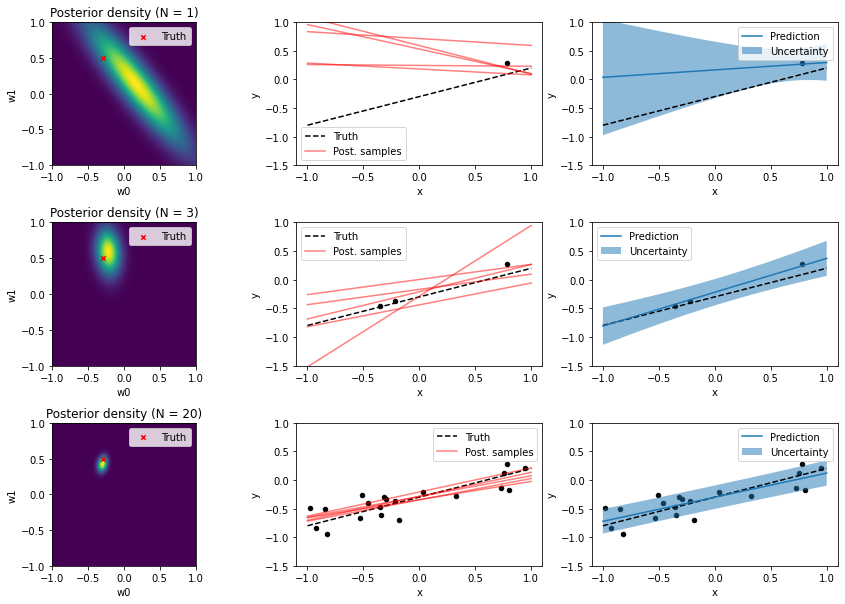

In [0]:

import matplotlib.pyplot as plt
%matplotlib inline

N_list = [1, 5, 40]

beta = 20.0
alpha = 5.0


X = np.random.rand(N_list[-1], 1) * 2 - 1

t = f(X, noise_variance=1/beta)

X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = f(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, identity_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, f_w0, f_w1)
    plt.title(f'Posterior density (N = {N})')
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.5, 1.0)
    plt.legend()

In [0]:
print(" The  Mean and covariance matrix of posterior distribution are :\n\n  Mean\t\n{} \n\n covariance Marix\t\n{}".format(m_N,S_N))

 The  Mean and covariance matrix of posterior distribution are :

  Mean	
[[-0.30139682]
 [ 0.42178343]] 

 covariance Marix	
[[0.00206884 0.00063529]
 [0.00063529 0.00525455]]


In [0]:
print(" The  Mean and covariance matrix of posterior predictive distribution are :\n\n  Mean\t\n{} \n\n covariance Marix\t\n{}".format(y,y_var))

 The  Mean and covariance matrix of posterior predictive distribution are :

  Mean	
[[-0.72318025]
 [-0.71465937]
 [-0.7061385 ]
 [-0.69761762]
 [-0.68909674]
 [-0.68057586]
 [-0.67205499]
 [-0.66353411]
 [-0.65501323]
 [-0.64649235]
 [-0.63797148]
 [-0.6294506 ]
 [-0.62092972]
 [-0.61240885]
 [-0.60388797]
 [-0.59536709]
 [-0.58684621]
 [-0.57832534]
 [-0.56980446]
 [-0.56128358]
 [-0.5527627 ]
 [-0.54424183]
 [-0.53572095]
 [-0.52720007]
 [-0.5186792 ]
 [-0.51015832]
 [-0.50163744]
 [-0.49311656]
 [-0.48459569]
 [-0.47607481]
 [-0.46755393]
 [-0.45903305]
 [-0.45051218]
 [-0.4419913 ]
 [-0.43347042]
 [-0.42494954]
 [-0.41642867]
 [-0.40790779]
 [-0.39938691]
 [-0.39086604]
 [-0.38234516]
 [-0.37382428]
 [-0.3653034 ]
 [-0.35678253]
 [-0.34826165]
 [-0.33974077]
 [-0.33121989]
 [-0.32269902]
 [-0.31417814]
 [-0.30565726]
 [-0.29713639]
 [-0.28861551]
 [-0.28009463]
 [-0.27157375]
 [-0.26305288]
 [-0.254532  ]
 [-0.24601112]
 [-0.23749024]
 [-0.22896937]
 [-0.22044849]
 [-0.21192761]
